In [44]:
import os
from pathlib import Path
home = os.getcwd()
current = home
while 'data' not in os.listdir(current):
    current = Path(current).parent
DATA_FOLDER = os.path.join(current, 'data')
PREPARED_DATA_FOLDER = os.path.join(current, 'prepared_data')

In [45]:
# let's try to understand which products bring the most profit
import pandas as pd
item_order_csv = os.path.join(DATA_FOLDER, 'olist_order_items_dataset.csv')
order_items = pd.read_csv(item_order_csv)
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [46]:
products_count = order_items.groupby('product_id')['price'].agg(['count']).sort_values('count', ascending=False)
products_count.head(20) 

,count
product_id,
aca2eb7d00ea1a7b8ebd4e68314663af,527
99a4788cb24856965c36a24e339b6058,488
422879e10f46682990de24d770e7f83d,484
389d119b48cf3043d311335e499d9c6b,392
368c6c730842d78016ad823897a372db,388
53759a2ecddad2bb87a079a1f1519f73,373
d1c427060a0f73f6b889a5c7c61f2ac4,343
53b36df67ebb7c41585e8d54d6772e08,323
154e7e31ebfa092203795c972e5804a6,281


In [47]:
# products_count = products_count[products_count['count'] <= 100]

Can we find enough statistical evidence to determine the significance of image quality and the length of the description on the popularity of the product ?

In [48]:
# let's merge some data
products = pd.read_csv(os.path.join(PREPARED_DATA_FOLDER, 'products_prepared.csv'))
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,40.0,287.0,1.0,225.0
1,96bd76ec8810374ed1b65e291975717f,sport leisure,46.0,250.0,1.0,154.0
2,cef67bcfe19066a932b7673e239eb23d,babies,27.0,261.0,1.0,371.0
3,9dc1a7de274444849c219cff195d0b71,housewares,37.0,402.0,4.0,625.0
4,732bd381ad09e530fe0a5f457d81becb,cool stuff,56.0,1272.0,4.0,18350.0


In [49]:
products_eval = pd.merge(left=products, right=products_count, how='inner', on='product_id')
len(products_eval)

27007

In [50]:
products_eval['product_photos_qty'].value_counts()
products_eval['multiple_phots'] = (products_eval['product_photos_qty'] >= 3).astype(int)

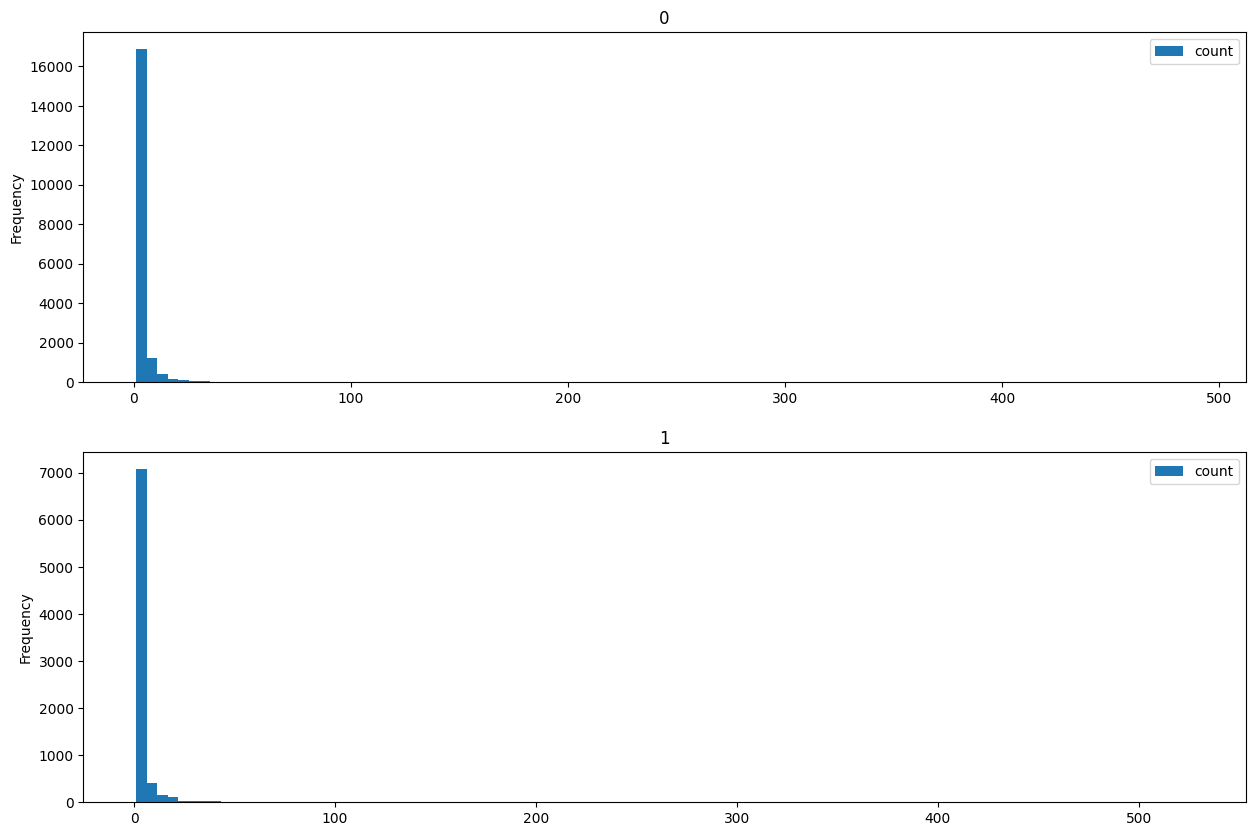

In [51]:
import matplotlib.pyplot as plt

products_eval.plot.hist(column='count', by='multiple_phots', figsize=(15, 10), bins=100)
# products['product_photos_qty'].hist(bins=range(0, len(categories), 3), figsize=(15, 8))
# plt.xticks(ticks=list(range(0, len(categories), 3)), rotation=90)
# plt.xlabel('categories: mapped to numer1ical values')
# plt.ylabel('frequencies')
# plt.title('frequencies of product categories')
plt.show()

In [56]:
# let's group the products by their categories and divide them further by their number of photos and decide whether the number of photos is somehow related to 
# populatiry of the product

# let's consider the most popular product categories
# product_categories = products_eval['product_category_name'].unique()
cats = products_eval['product_category_name'].value_counts().index.tolist()

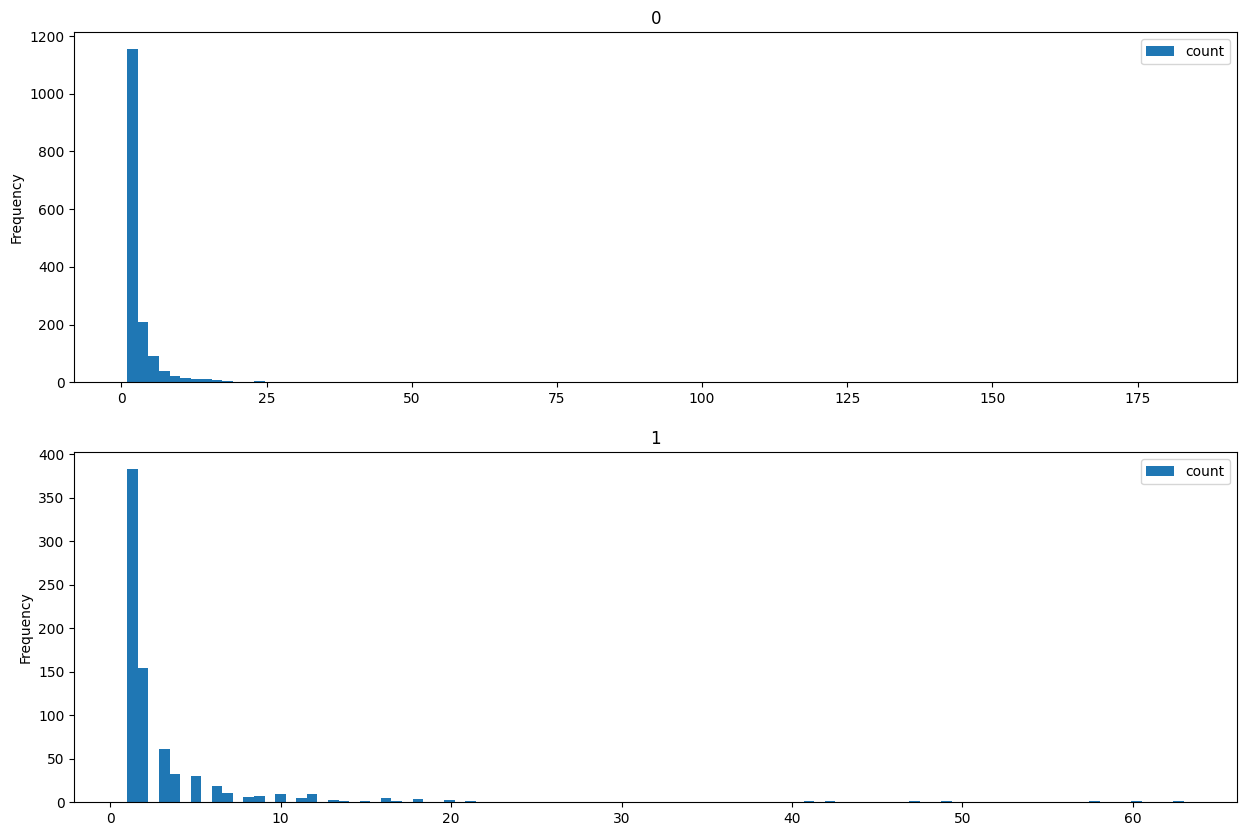

In [59]:
cat1_prod_eval = products_eval[products_eval['product_category_name'] == cats[4]]
cat1_prod_eval.plot.hist(column='count', by='multiple_phots', figsize=(15, 10), bins=100)
# products['product_photos_qty'].hist(bins=range(0, len(categories), 3), figsize=(15, 8))
# plt.xticks(ticks=list(range(0, len(categories), 3)), rotation=90)
# plt.xlabel('categories: mapped to numer1ical values')
# plt.ylabel('frequencies')
# plt.title('frequencies of product categories')
plt.show()